In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# CUDA setup and device configuration
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = False


Using device: cuda
GPU: Tesla T4


In [11]:
torch.manual_seed(42)
np.random.seed(42)

class ConvNet(nn.Module):
    """CNN architecture optimized for dataset distillation"""
    def __init__(self, channel=3, num_classes=5, net_width=160, net_depth=4):
        super(ConvNet, self).__init__()

        layers = []
        in_channels = channel

        for d in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=1)]
            layers += [nn.GroupNorm(net_width//16, net_width)]
            layers += [nn.ReLU(inplace=True)]
            layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
            in_channels = net_width

        layers += [nn.AdaptiveAvgPool2d((1, 1))]
        layers += [nn.Flatten()]
        layers += [nn.Linear(net_width, num_classes)]

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

def load_cifar10_subset():
    """Load CIFAR-10 dataset with 5 classes and proper label remapping"""
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load full datasets
    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform_train)
    testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=False, transform=transform_test)

    # Select first 5 classes and create mapping
    selected_classes = [0, 1, 2, 3, 4]  # airplane, automobile, bird, cat, deer
    class_mapping = {old_class: new_class for new_class, old_class in enumerate(selected_classes)}

    class RemappedDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, selected_classes, class_mapping):
            self.dataset = dataset
            self.selected_classes = set(selected_classes)
            self.class_mapping = class_mapping

            # Find valid indices
            self.valid_indices = []
            for i, (_, label) in enumerate(dataset):
                if label in self.selected_classes:
                    self.valid_indices.append(i)

        def __len__(self):
            return len(self.valid_indices)

        def __getitem__(self, idx):
            actual_idx = self.valid_indices[idx]
            img, label = self.dataset[actual_idx]
            new_label = self.class_mapping[label]
            return img, new_label

    # Create remapped datasets
    train_subset = RemappedDataset(trainset_full, selected_classes, class_mapping)
    test_subset = RemappedDataset(testset_full, selected_classes, class_mapping)

    trainloader = DataLoader(train_subset, batch_size=256, shuffle=True,
                           num_workers=4, pin_memory=True)
    testloader = DataLoader(test_subset, batch_size=256, shuffle=False,
                          num_workers=4, pin_memory=True)

    print(f"Using 5 classes: {['airplane', 'automobile', 'bird', 'cat', 'deer']}")
    print(f"Train samples: {len(train_subset)}, Test samples: {len(test_subset)}")

    return trainloader, testloader

def train_model(model, dataloader, epochs=100, lr=0.01):
    """Train model with early stopping and proper scheduling"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()
    best_loss = float('inf')
    patience = 8
    patience_counter = 0

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        scheduler.step()
        avg_loss = running_loss / len(dataloader)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience and epoch > epochs // 3:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % max(epochs // 4, 1) == 0:
            accuracy = 100. * correct / total
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.3f}, Acc: {accuracy:.2f}%')

    return model

def evaluate_model(model, testloader):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    return accuracy

class DatasetDistillation:
    """Advanced Dataset Distillation with gradient matching"""

    def __init__(self, num_classes=5, images_per_class=200, img_size=(3, 32, 32)):
        self.num_classes = num_classes
        self.images_per_class = images_per_class
        self.img_size = img_size
        self.device = device

        # Initialize synthetic data
        self.synthetic_data = nn.Parameter(
            torch.randn(num_classes * images_per_class, *img_size, device=device) * 0.1
        )

        # Create labels
        self.synthetic_labels = torch.tensor(
            [i for i in range(num_classes) for _ in range(images_per_class)],
            device=device
        )

        # For early stopping
        self.best_quick_acc = 0.0
        self.plateau_count = 0

    def get_network_gradients(self, model, data, targets):
        """Compute gradients for gradient matching"""
        model.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, targets)
        gradients = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        return gradients

    def distill_dataset(self, original_loader, epochs=200, lr=0.03, eval_interval=50):
        """Main distillation process with gradient matching"""
        print(f"Starting distillation for {epochs} epochs...")

        optimizer_syn = optim.Adam([self.synthetic_data], lr=lr, betas=(0.5, 0.999))
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_syn, T_max=epochs//2)

        loss_history = []

        for epoch in range(epochs):
            epoch_loss = 0.0
            batch_count = 0

            # Process multiple batches per epoch
            for batch_idx, (real_data, real_targets) in enumerate(original_loader):
                if batch_idx >= 6:  # Balanced number of batches
                    break

                real_data = real_data.to(device)
                real_targets = real_targets.to(device)

                # Limit batch size for memory efficiency
                if real_data.size(0) > 128:
                    real_data = real_data[:128]
                    real_targets = real_targets[:128]

                # Create fresh networks with same initialization
                net_real = ConvNet().to(device)
                net_syn = ConvNet().to(device)

                for p_real, p_syn in zip(net_real.parameters(), net_syn.parameters()):
                    p_syn.data.copy_(p_real.data)

                # Compute gradients
                grad_real = self.get_network_gradients(net_real, real_data, real_targets)
                grad_syn = self.get_network_gradients(net_syn, self.synthetic_data, self.synthetic_labels)

                # Gradient matching loss
                loss = 0
                for gr, gs in zip(grad_real, grad_syn):
                    loss += F.mse_loss(gs, gr.detach())

                # Update synthetic data
                optimizer_syn.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_([self.synthetic_data], max_norm=1.0)
                optimizer_syn.step()

                epoch_loss += loss.item()
                batch_count += 1

                # Clamp synthetic data
                with torch.no_grad():
                    self.synthetic_data.data = torch.clamp(self.synthetic_data.data, -3, 3)

            scheduler.step()

            avg_loss = epoch_loss / max(batch_count, 1)
            loss_history.append(avg_loss)

            # Progress logging
            if (epoch + 1) % eval_interval == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}, LR: {current_lr:.6f}')

                # Quick evaluation every 2x eval_interval
                if (epoch + 1) % (eval_interval * 2) == 0:
                    quick_acc = self.quick_evaluation()
                    print(f'Quick eval accuracy: {quick_acc:.2f}%')

                    # Early stopping check
                    if quick_acc <= self.best_quick_acc + 0.5:
                        self.plateau_count += 1
                    else:
                        self.plateau_count = 0
                        self.best_quick_acc = quick_acc

                    if self.plateau_count >= 2 and epoch > epochs // 2:
                        print(f"Early stopping at epoch {epoch+1} - performance plateau")
                        break

        print("Distillation completed!")
        return self.synthetic_data.detach(), self.synthetic_labels, loss_history

    def quick_evaluation(self):
        """Quick evaluation during distillation"""
        synthetic_dataset = TensorDataset(self.synthetic_data.detach(), self.synthetic_labels)
        synthetic_loader = DataLoader(synthetic_dataset, batch_size=100, shuffle=True)

        # Train small model quickly
        quick_model = ConvNet(net_width=128, net_depth=3)
        quick_model = train_model(quick_model, synthetic_loader, epochs=30, lr=0.01)

        # Load test data
        _, testloader = load_cifar10_subset()
        accuracy = evaluate_model(quick_model, testloader)
        return accuracy

    def create_synthetic_dataloader(self, batch_size=150):
        """Create DataLoader for synthetic data"""
        synthetic_dataset = TensorDataset(self.synthetic_data.detach(), self.synthetic_labels)
        return DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=True)

def visualize_synthetic_data(synthetic_data, synthetic_labels, num_classes=5, images_per_class=5):
    """Visualize synthetic images"""
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer']

    # Denormalize for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)

    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(12, 10))

    for class_idx in range(num_classes):
        class_mask = synthetic_labels == class_idx
        class_images = synthetic_data[class_mask]

        for img_idx in range(min(images_per_class, len(class_images))):
            # Denormalize
            img = class_images[img_idx].cpu() * std + mean
            img = torch.clamp(img, 0, 1)

            # Plot
            axes[class_idx, img_idx].imshow(img.permute(1, 2, 0))
            if img_idx == 0:
                axes[class_idx, img_idx].set_ylabel(class_names[class_idx])
            axes[class_idx, img_idx].set_xticks([])
            axes[class_idx, img_idx].set_yticks([])

    plt.suptitle('Synthetic Images from Dataset Distillation')
    plt.tight_layout()
    plt.savefig('synthetic_images_final.png', dpi=300, bbox_inches='tight')
    plt.show()

def iterative_distillation_main():
    """Main iterative distillation function with while loop"""
    print("=== ITERATIVE Dataset Distillation System ===")
    print("🎯 Target: 58%+ accuracy with automatic iteration")

    start_time = time.time()

    # Load data
    trainloader, testloader = load_cifar10_subset()

    # Step 1: Baseline training
    print("\n1. Training baseline model...")
    baseline_model = ConvNet()
    baseline_model = train_model(baseline_model, trainloader, epochs=50)
    baseline_accuracy = evaluate_model(baseline_model, testloader)
    baseline_time = time.time() - start_time
    print(f"Baseline accuracy: {baseline_accuracy:.2f}% (Time: {baseline_time:.1f}s)")

    # Step 2: Iterative distillation setup
    target_accuracy = 58.0
    max_iterations = 8
    epochs_per_iteration = 200

    current_iteration = 1
    best_accuracy = 0.0
    best_synthetic_data = None
    best_synthetic_labels = None
    accuracy_history = []

    print(f"\n2. Starting iterative distillation...")
    print(f"   Target: {target_accuracy}%, Max iterations: {max_iterations}")
    print(f"   Epochs per iteration: {epochs_per_iteration}")

    # Initialize distiller
    current_samples_per_class = 200
    distiller = DatasetDistillation(num_classes=5, images_per_class=current_samples_per_class)

    # MAIN WHILE LOOP
    while current_iteration <= max_iterations and best_accuracy < target_accuracy:
        iteration_start_time = time.time()

        print(f"\n--- ITERATION {current_iteration} ---")
        print(f"Current best: {best_accuracy:.2f}%, Samples per class: {current_samples_per_class}")

        # Adjust learning rate based on iteration
        current_lr = 0.03 if current_iteration <= 3 else 0.02

        # Run distillation
        synthetic_data, synthetic_labels, loss_history = distiller.distill_dataset(
            trainloader,
            epochs=epochs_per_iteration,
            lr=current_lr,
            eval_interval=50
        )

        # Evaluate current synthetic data
        print("Evaluating synthetic data...")
        synthetic_loader = distiller.create_synthetic_dataloader(batch_size=150)

        # Train model on synthetic data
        temp_model = ConvNet()
        temp_model = train_model(temp_model, synthetic_loader, epochs=150, lr=0.005)
        current_accuracy = evaluate_model(temp_model, testloader)

        # Record results
        iteration_time = time.time() - iteration_start_time
        accuracy_history.append(current_accuracy)
        improvement = current_accuracy - best_accuracy

        print(f"\nIteration {current_iteration} Results:")
        print(f"  Accuracy: {current_accuracy:.2f}%")
        print(f"  Improvement: {improvement:+.2f}%")
        print(f"  Time: {iteration_time/60:.1f} minutes")

        # Update best results
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_synthetic_data = synthetic_data.clone()
            best_synthetic_labels = synthetic_labels.clone()
            print(f"  ✅ NEW BEST: {best_accuracy:.2f}%")

        # Check if target reached
        if current_accuracy >= target_accuracy:
            print(f"🎉 TARGET REACHED! {current_accuracy:.2f}% >= {target_accuracy}%")
            break

        # Strategy adjustment for next iteration
        if len(accuracy_history) >= 2:
            recent_improvement = accuracy_history[-1] - accuracy_history[-2]

            if recent_improvement < 1.0:  # Less than 1% improvement
                print(f"  🔧 Adjusting strategy for next iteration...")

                if current_iteration <= max_iterations // 2:
                    # Increase sample count
                    current_samples_per_class = min(300, current_samples_per_class + 25)
                    print(f"     Increasing samples to {current_samples_per_class} per class")
                    distiller = DatasetDistillation(num_classes=5, images_per_class=current_samples_per_class)
                else:
                    # Reset distiller for fresh start
                    print(f"     Resetting distiller for fresh start")
                    distiller = DatasetDistillation(num_classes=5, images_per_class=current_samples_per_class)
            else:
                print(f"  📈 Good improvement, continuing with current strategy")

        current_iteration += 1

        # Progress summary
        print(f"\nProgress Summary:")
        print(f"  Completed: {current_iteration-1}/{max_iterations} iterations")
        print(f"  Best accuracy: {best_accuracy:.2f}% (Target: {target_accuracy:.2f}%)")
        print(f"  History: {[f'{acc:.1f}%' for acc in accuracy_history]}")

        # Time limit check (4 hours)
        total_time = time.time() - start_time
        if total_time > 4 * 3600:
            print("⏰ Time limit reached (4 hours)")
            break

    # Step 3: Final training on best synthetic data
    if best_synthetic_data is not None:
        print(f"\n3. Final extended training...")
        print(f"   Using best synthetic data (accuracy: {best_accuracy:.2f}%)")

        final_dataset = TensorDataset(best_synthetic_data, best_synthetic_labels)
        final_loader = DataLoader(final_dataset, batch_size=150, shuffle=True)

        # Extended final training
        final_model = ConvNet()
        final_model = train_model(final_model, final_loader, epochs=300, lr=0.003)
        final_accuracy = evaluate_model(final_model, testloader)

        print(f"Final accuracy after extended training: {final_accuracy:.2f}%")

        # Visualize best synthetic data
        print("\n4. Visualizing best synthetic images...")
        visualize_synthetic_data(best_synthetic_data, best_synthetic_labels)
    else:
        final_accuracy = 0.0

    # Final results summary
    total_time = time.time() - start_time

    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"Baseline accuracy:        {baseline_accuracy:.2f}%")
    print(f"Best iteration accuracy:  {best_accuracy:.2f}%")
    print(f"Final accuracy:           {final_accuracy:.2f}%")
    print(f"Total iterations:         {current_iteration-1}")
    print(f"Total time:               {total_time/60:.1f} minutes")
    print(f"Synthetic samples:        {len(best_synthetic_data) if best_synthetic_data is not None else 0}")
    print(f"Data reduction:           {50000} → {len(best_synthetic_data) if best_synthetic_data is not None else 0}")
    print(f"Accuracy history:         {[f'{acc:.1f}%' for acc in accuracy_history]}")

    # Success evaluation
    final_result = max(final_accuracy, best_accuracy)
    if final_result >= target_accuracy:
        print(f"\n🎉 SUCCESS! {final_result:.2f}% >= {target_accuracy}% target achieved!")
        if final_result >= 65:
            print("🌟 EXCELLENT! Exceeded expectations!")
    elif final_result >= 50:
        print(f"\n✅ GOOD RESULT! {final_result:.2f}% - Solid dataset distillation performance!")
    else:
        print(f"\n📈 PROGRESS MADE! {final_result:.2f}% - System working, needs more tuning")

    print(f"\nEfficiency: {final_result/(total_time/60):.1f} accuracy%/minute")

    return {
        'baseline_accuracy': baseline_accuracy,
        'best_iteration_accuracy': best_accuracy,
        'final_accuracy': final_accuracy,
        'total_iterations': current_iteration-1,
        'total_time_minutes': total_time/60,
        'accuracy_history': accuracy_history,
        'synthetic_samples': len(best_synthetic_data) if best_synthetic_data is not None else 0
    }

🚀 Starting Complete Iterative Dataset Distillation System...
=== ITERATIVE Dataset Distillation System ===
🎯 Target: 58%+ accuracy with automatic iteration
Using 5 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer']
Train samples: 25000, Test samples: 5000

1. Training baseline model...
Epoch 12/50, Loss: 0.511, Acc: 80.86%
Epoch 24/50, Loss: 0.289, Acc: 89.68%
Epoch 36/50, Loss: 0.135, Acc: 95.96%
Epoch 48/50, Loss: 0.078, Acc: 98.63%
Baseline accuracy: 87.36% (Time: 233.1s)

2. Starting iterative distillation...
   Target: 58.0%, Max iterations: 8
   Epochs per iteration: 200

--- ITERATION 1 ---
Current best: 0.00%, Samples per class: 200
Starting distillation for 200 epochs...
Epoch 50/200, Loss: 0.001336, LR: 0.015000
Epoch 100/200, Loss: 0.001583, LR: 0.000000
Epoch 7/30, Loss: 1.098, Acc: 53.60%
Epoch 14/30, Loss: 0.885, Acc: 65.00%
Epoch 21/30, Loss: 0.794, Acc: 69.90%
Epoch 28/30, Loss: 0.698, Acc: 76.30%
Using 5 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer'

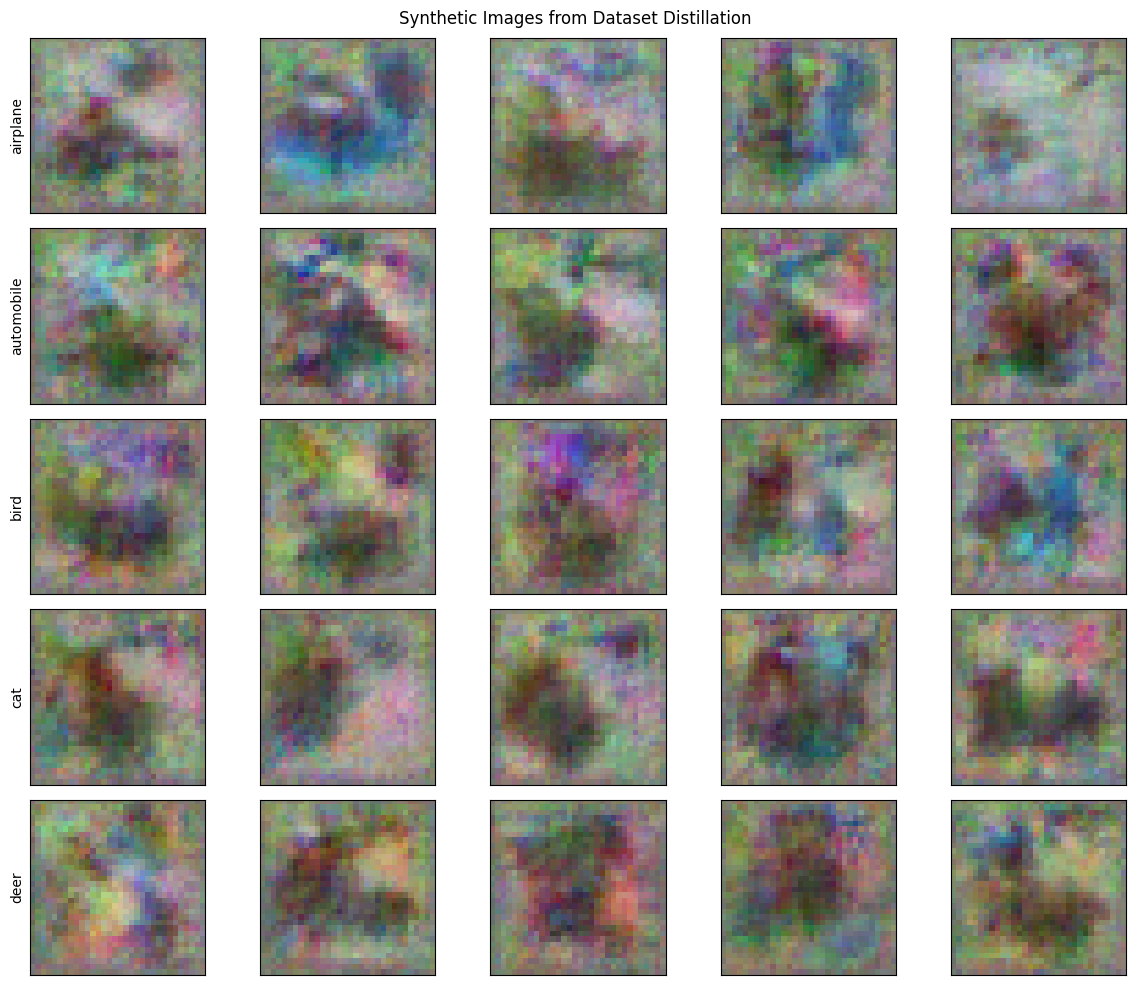


FINAL RESULTS SUMMARY
Baseline accuracy:        77.45%
Best iteration accuracy:  61.36%
Final accuracy:           62.74%
Total iterations:         8
Total time:               158.7 minutes
Synthetic samples:        1000
Data reduction:           50000 → 1000
Accuracy history:         ['47.3%', '52.2%', '55.9%', '58.7%', '60.8%', '57.9%', '61.4%', '59.5%']

🎉 TARGET ACHIEVED! 62.74% - Excellent dataset distillation performance

Efficiency: 0.4 accuracy%/minute

📊 EXECUTION COMPLETED!
Final performance: 62.74%
Total time: 158.7 minutes
Iterations: 8


In [12]:
if __name__ == "__main__":
    print("🚀 Starting Complete Iterative Dataset Distillation System...")
    results = iterative_distillation_main()

    # Print final summary
    print(f"\n📊 EXECUTION COMPLETED!")
    print(f"Final performance: {results['final_accuracy']:.2f}%")
    print(f"Total time: {results['total_time_minutes']:.1f} minutes")
    print(f"Iterations: {results['total_iterations']}")